In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
import matplotlib.patches as mpatches
import pyproj
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe
from geopy.distance import geodesic
import geopy
import matplotlib.colors 
import matplotlib.patches as patches

In [2]:
debug = False

Final event location

In [3]:
eve_lat = 72.50
eve_lon = -27.30

In [4]:
stas, lats, lons, BAZs, corrs, Vs, Rs,Ts, RAs, TAs, HRs, Ms = [],[],[],[],[],[],[],[],[],[],[],[]
Data_file = open('./92s_RT_Final_Sept16.txt')
for line in Data_file:
    Col = line.split(' , ')
    sta, lat, lon = str(Col[0].split(".")[1]),float(Col[1]), float(Col[2])

    #if sta not in ["SFJD", "ALE"]:
    #    continue
    
    if debug:
        print(Col)
    # convert BAZ to the CCW format quiver wants (-1 * BAZ-90)
    BAZ = float(Col[3])
    #RA = float(Col[8])
    corr,V,R,T = float(Col[4]),float(Col[5]),float(Col[6]),float(Col[7])
    #TA = RA + 90.
    HR = np.log10(T/R)
    M = Col[9]
    stas.append(sta),lats.append(lat),lons.append(lon)
    BAZs.append(BAZ),corrs.append(corr), Vs.append(V),Rs.append(R),Ts.append(T)
    #RAs.append(RA), TAs.append(TA)
    HRs.append(HR), Ms.append(M)

In [5]:
DFJ_lons = [-40.153, -13.801]
DFJ_lats = [71.015, 73.606]

In [6]:
LNP_lons = [-26.9716, 79.0708, 153.0283, -84.1053, -26.9716]
LNP_lats = [72.8358, 9.2891, -72.8353, 39.7624, 72.8358]

In [7]:
RNP_lons = [-26.9716, -10.3422, 153.0283, 177.0588, -26.9716]
RNP_lats = [72.8358, 6.2717, -72.8353, 52.2190, 72.8358]

Make the Plot

In [8]:
def compute_radius(ortho, lon, lat, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)



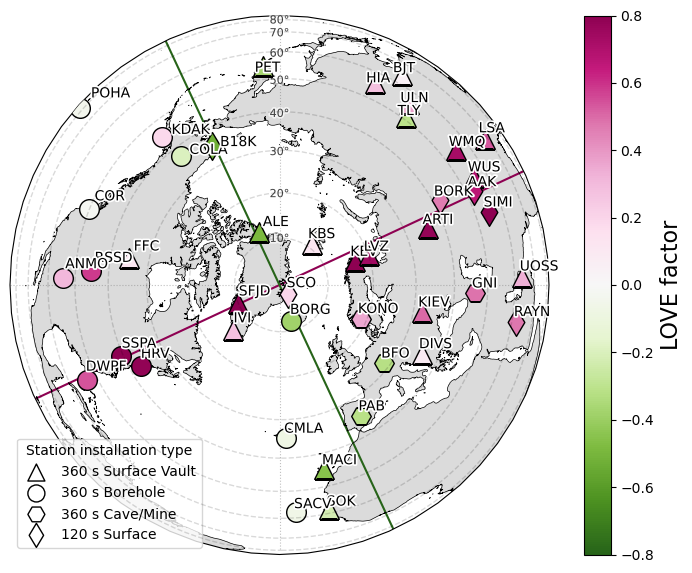

In [9]:
fig = plt.figure(1,figsize=(9,7),facecolor='w')

#plateCr = ccrs.NorthPolarStereo(central_longitude=-26.0)
#plateCr = ccrs.Stereographic(central_latitude=72.5, central_longitude=-26,
#                             false_easting=0.0, false_northing=.0, true_scale_latitude=72.5, globe=None)

c_lon=  -26
c_lat = 72.5

plateCr = ccrs.Orthographic(central_longitude=eve_lon, central_latitude=eve_lat)
# print(plateCr._threshold) # original threshold=0.5
#plateCr._threshold = plateCr._threshold/10.  #set finer threshold
ax1 = plt.axes(projection=plateCr)

ax1.coastlines(resolution='50m', zorder=3, lw=0.5) # zorder=3 makes sure that no other plots overlay the coastlines
gl = ax1.gridlines(crs=plateCr, color='grey', alpha=0.5, linestyle=':')
gl.xlocator=mticker.FixedLocator([0])
gl.ylocator=mticker.FixedLocator([0])

# This is necesary to make the latitude lines look circular

ax1.set_global()
ax1.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])

# Plot nodal lines

destination1 =  geopy.distance.great_circle(90*110).destination(geopy.Point(eve_lat, eve_lon), 65)
destination2 =  geopy.distance.great_circle(90*110).destination(geopy.Point(eve_lat, eve_lon), 65-180)
xx1, yy1 = plateCr.transform_point(destination1.longitude, destination1.latitude, ccrs.Geodetic())
xx2, yy2 = plateCr.transform_point(destination2.longitude, destination2.latitude, ccrs.Geodetic())
ax1.plot([xx1, xx2], [yy1, yy2], transform=plateCr, c=plt.get_cmap("PiYG_r")(255))

destination1 =  geopy.distance.great_circle(90*110).destination(geopy.Point(eve_lat, eve_lon), 65+90)
destination2 =  geopy.distance.great_circle(90*110).destination(geopy.Point(eve_lat, eve_lon), 65+90-180)
xx1, yy1 = plateCr.transform_point(destination1.longitude, destination1.latitude, ccrs.Geodetic())
xx2, yy2 = plateCr.transform_point(destination2.longitude, destination2.latitude, ccrs.Geodetic())
ax1.plot([xx1, xx2], [yy1, yy2], transform=plateCr, c=plt.get_cmap("PiYG_r")(0))


## Plot great circle radii every 10deg and label them
for rad in np.arange(10, 90, 10):
    r_or = compute_radius(plateCr, c_lon, c_lat, rad)
    mapx, mapy = plateCr.transform_point(c_lon, c_lat, ccrs.PlateCarree())
    c = mpatches.Circle(xy=(mapx, mapy), radius=r_or, color='None', ec="k", alpha=0.15, transform=plateCr, zorder=30,
                        ls="--")
    ax1.add_patch(c)
    destination =  geopy.distance.distance(rad*110).destination(geopy.Point(eve_lat, eve_lon), 0)
    xx, yy = plateCr.transform_point(destination.longitude, destination.latitude, ccrs.Geodetic())
    ax1.text(xx, yy, f"{rad}°", transform=plateCr, fontsize=8, ha="center", va="center", path_effects=[pe.withStroke(linewidth=2.5, foreground="white")], alpha=0.65)


# Legend items
sc2 = ax1.scatter(0,-90,s=150,c='none',edgecolor='k', marker = '^', label = '360 s Surface Vault',transform = ccrs.PlateCarree())
sc2 = ax1.scatter(0,-90,s=150,c='none',edgecolor='k', marker = 'o', label = '360 s Borehole',transform = ccrs.PlateCarree())
sc2 = ax1.scatter(0,-90,s=150,c='none',edgecolor='k', marker = 'H', label = '360 s Cave/Mine',transform = ccrs.PlateCarree())
sc2 = ax1.scatter(0,-90,s=150,c='none',edgecolor='k', marker = 'd', label = '120 s Surface',transform = ccrs.PlateCarree())

# Plot station observations and labels
for nz, staP in enumerate(zip(lons,lats,HRs,Ms,stas)):
    sc = ax1.scatter(staP[0],staP[1],s=200,c=staP[2],zorder=4, marker=staP[3], edgecolor='k', transform = ccrs.PlateCarree(),
                        cmap='PiYG_r', vmin=-0.8, vmax=0.8 )
    ax1.text(staP[0]+ 0.02*staP[0],staP[1]+1.5,staP[4], c = 'k', transform = ccrs.PlateCarree(), zorder=5,
            path_effects=[pe.withStroke(linewidth=2.5, foreground="white")])

ax1.legend(title="Station installation type", loc="lower left")

# Colorbar
cbar = fig.colorbar(sc, orientation='vertical')
cbar.set_label('LOVE factor',fontsize=16)

plt.savefig("lovefacto-nodes-all.png", dpi=300, bbox_inches="tight", transparent=True)